In [108]:
using Flux
using Gen
using Random
using Distributions

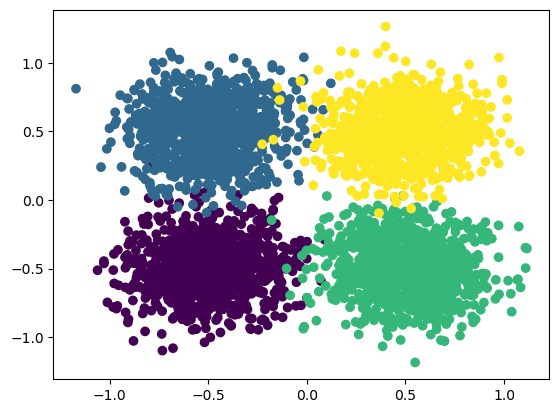

PyObject <matplotlib.collections.PathCollection object at 0x7f83cb15e4d0>

In [288]:
#Generate Data
n = 1000
Σ = [0.04 0.0; 0.0 0.04]
mu1 = [-0.5, -0.5]
mu2 = [-0.5, 0.5]
mu3 = [0.5, -0.5]
mu4 = [0.5, 0.5]

d1 = MvNormal(mu1, Σ)
d2 = MvNormal(mu2, Σ)
d3 = MvNormal(mu3, Σ)
d4 = MvNormal(mu4, Σ)

x1 = rand(d1,1000)
x2 = rand(d2,1000)
x3 = rand(d3,1000)
x4 = rand(d4,1000)
x = hcat(x1, x2, x3, x4)

labels = [round(i/n % n, RoundDown) + 1 for i in range(0, 4n-1, step=1)]
y = float(Flux.onehotbatch(labels, [1,2,3,4]))
scatter(x[1,:],x[2,:], c=labels)

In [289]:
dataset = zip(Flux.unstack(transpose(x),1),Flux.unstack(transpose(y),1));

In [310]:
#Make a Neural Network
model = Chain(
  Dense(2, 5, σ),
  Dense(5, 4),
  softmax)

loss(x, y) = Flux.crossentropy(model(x), y)
opt = Flux.ADAM()

#@Flux.epochs 10 Flux.train!(loss, Flux.params(model), dataset, opt);
for i in range(1,100,step=1)
    Flux.train!(loss, Flux.params(model), dataset, opt)
    if i % 5 == 0
        predictions = mapslices(argmax,model(x),dims=1)
        labels_accurate = [x == y ? 1 : 0 for (x,y) in zip(labels,predictions)]
        accuracy = sum(labels_accurate)/(4n)
        display(accuracy)
    end
end

0.93525

0.98375

0.9855

0.98575

0.986

0.9865

0.9865

0.9865

0.9865

0.9865

0.9865

0.986

0.986

0.986

0.986

0.98625

0.986

0.986

0.98625

0.986

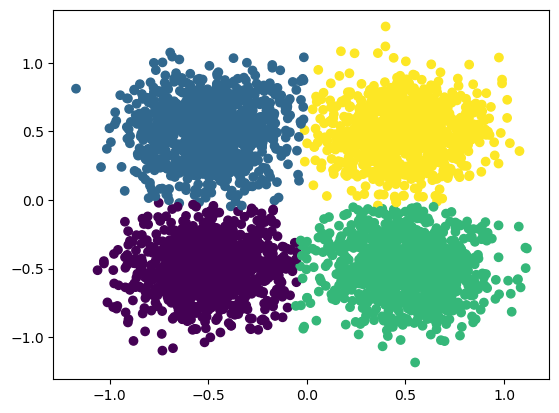

0.986

In [311]:
predictions = mapslices(argmax,model(x),dims=1)
scatter(x[1,:],x[2,:], c=predictions)
labels_accurate = [x == y ? 1 : 0 for (x,y) in zip(labels,predictions)]
accuracy = sum(labels_accurate)/(4n)

In [435]:
using LinearAlgebra
using Turing

##########
#Bayes Net
##########
function unpack(nn_params::AbstractVector)
    W₁ = reshape(nn_params[1:6], 3, 2);   
    b₁ = reshape(nn_params[7:9], 3)
    
    W₂ = reshape(nn_params[10:21], 4, 3); 
    b₂ = reshape(nn_params[22:25], 4)

    return W₁, b₁, W₂, b₂
end

# Construct a neural network using Flux and return a predicted value.
function nn_forward(xs, nn_params::AbstractVector)
    W₁, b₁, W₂, b₂ = unpack(nn_params)
    nn = Chain(Dense(W₁, b₁, tanh),
               Dense(W₂, b₂, tanh),
               softmax)
    return nn(xs)
end;

# Create a regularization term and a Gaussain prior variance term.
alpha = 0.09
sig = sqrt(1.0 / alpha)

# Specify the probabalistic model.
@gen function bayes_nn(xs, ts)
    # Create the weight and bias vector.
    μ = zeros(25)
    Σ = Diagonal(ones(25))
    nn_params = @trace(mvnormal(μ,Σ), :p)
    
    # Calculate predictions for the inputs given the weights
    # and biases in theta.
    preds = nn_forward(xs, nn_params)
    
    for i=1:length(y[1,:])
        @trace(categorical(preds[:,i]), (:y, i)) 
    end
end;

bayes_nn(x,y)

# Perform inference.
N = 5000
ch = sample(bayes_nn(x, y), HMC(0.05, 4), N);

MethodError: MethodError: no method matching sample(::Nothing, ::HMC{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.UnitEuclideanMetric}, ::Int64)
Closest candidates are:
  sample(!Matched::AbstractMCMC.AbstractModel, ::Turing.Inference.InferenceAlgorithm, ::Integer; kwargs...) at /home/jberez/.julia/packages/Turing/q3coT/src/inference/Inference.jl:141
  sample(!Matched::AbstractRNG, !Matched::AbstractArray{T,N} where N, ::Integer; replace, ordered) where T at /home/jberez/.julia/packages/StatsBase/unDUx/src/sampling.jl:459
  sample(!Matched::AbstractArray, !Matched::AbstractWeights, ::Integer; replace, ordered) at /home/jberez/.julia/packages/StatsBase/unDUx/src/sampling.jl:874
  ...